In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use("default")
rc = {"figure.figsize": (4, 3), "figure.dpi": 150, "figure.constrained_layout.use": True, "axes.grid": True, 
      "axes.spines.right": False, "axes.spines.top": False, "axes.linewidth": 0.6, "grid.linewidth": 0.6,
      "xtick.major.width": 0.6, "ytick.major.width": 0.6, "xtick.major.size": 4, "ytick.major.size": 4, 
      "axes.labelsize": 14, "axes.titlesize": 14, "xtick.labelsize": 12, "ytick.labelsize": 12,
      "axes.titlepad": 4, "axes.labelpad": 2, "xtick.major.pad": 2, "ytick.major.pad": 2,
      "lines.linewidth": 1.2, "patch.linewidth": 0}
sns.set_theme(style='ticks', palette=sns.color_palette("colorblind"), rc=rc)
import torch
from composer import Trainer
from composer.algorithms import ChannelsLast
from composer.datasets import DataLoaderHparams
from composer.optim import SGDHparams
from composer.optim.scheduler import ConstantScheduler
from composer.loggers import InMemoryLogger, TQDMLogger
from composer.utils import reproducibility
from composer.utils.object_store import ObjectStoreProviderHparams
from lth_diet.data import CIFAR100DataHparams
from lth_diet.data.data_diet import SubsetByScore
from lth_diet.models import ResNetClassifierHparams
from tqdm.notebook import tqdm
object_store = ObjectStoreProviderHparams('google_storage', 'prunes', 'GCS_KEY').initialize_object()

---

Train ResNet-50 on the entire CIFAR-100 dataset for 1600 steps, saving and evaluating the model on train and test sets every 50 steps.

In [ ]:
# EXP_NAME = "resnet_50__cifar100_all_data"
# DEVICE = "gpu"
# REPLICATE = 1
# BATCH_SIZE = 128
# VAL_BATCH_SIZE = 1000
# MAX_DURATION = "400ba"
# INTERVAL = 10

# MODEL_HPARAMS = ResNetClassifierHparams(num_classes=100, num_layers=50, low_res=True)
# DATA_HPARMS = CIFAR100DataHparams(train=True)
# VAL_DATA_HPARAMS = CIFAR100DataHparams(train=False)

# os.makedirs(f"../exps/rank_0/{EXP_NAME}/rep_{REPLICATE}")
# seed = 2022 * (REPLICATE + 1)
# reproducibility.seed_all(seed)
# model = MODEL_HPARAMS.initialize_object()
# torch.save(model.state_dict(), f"../exps/rank_0/{EXP_NAME}/rep_{REPLICATE}/ba_0.pt")
# reproducibility.seed_all(42)
# dataloader = DATA_HPARMS.initialize_object(
#     BATCH_SIZE, DataLoaderHparams(persistent_workers=False), object_store=object_store
# )
# val_dataloader = VAL_DATA_HPARAMS.initialize_object(VAL_BATCH_SIZE, DataLoaderHparams(persistent_workers=False))
# optimizer = SGDHparams(lr=0.1, momentum=0.9, weight_decay=0.0005, nesterov=True).initialize_object(model.parameters())
# scheduler = [ConstantScheduler()]
# algorithms = [ChannelsLast()]
# loggers = [InMemoryLogger(), TQDMLogger()]

# trainer = Trainer(
#     model = model,
#     train_dataloader=dataloader,
#     max_duration=MAX_DURATION,
#     eval_dataloader=val_dataloader,
#     algorithms=algorithms,
#     optimizers=optimizer,
#     schedulers=scheduler,
#     device=DEVICE,
#     validate_every_n_batches=INTERVAL,
#     precision="amp",
#     step_schedulers_every_batch=True,
#     seed=seed,
#     loggers=loggers,
#     save_folder=f"{EXP_NAME}/rep_{REPLICATE}",
#     save_name_format="ba_{batch}.pt",
#     save_interval=f"{INTERVAL}ba",
# )

# trainer.fit()

---

Train ResNet-50 on 2048 easiest CIFAR-100 examples for 1600 steps, saving and evaluating the model on train and test sets every 50 steps.

In [4]:
EXP_NAME = "resnet_50__cifar100_easy_data"
DEVICE = "gpu"
REPLICATE = 1
SUBSET_SIZE = 2048
BATCH_SIZE = 128
VAL_BATCH_SIZE = 1000
MAX_DURATION = "400ba"
INTERVAL = 10

MODEL_HPARAMS = ResNetClassifierHparams(num_classes=100, num_layers=50, low_res=True)
DATA_TRANSFORMS = [
    SubsetByScore(score="error_norm_cifar100_resnet50_7800ba_16reps_seed789", size=SUBSET_SIZE, class_balanced=True)
]
DATA_HPARMS = CIFAR100DataHparams(train=True, dataset_transforms=DATA_TRANSFORMS)
VAL_DATA_HPARAMS = CIFAR100DataHparams(train=False)

os.makedirs(f"../exps/rank_0/{EXP_NAME}/rep_{REPLICATE}", exist_ok=True)
seed = 2022 * (REPLICATE + 1)
reproducibility.seed_all(seed)
model = MODEL_HPARAMS.initialize_object()
torch.save(model.state_dict(), f"../exps/rank_0/{EXP_NAME}/rep_{REPLICATE}/ba_0.pt")
reproducibility.seed_all(42)
dataloader = DATA_HPARMS.initialize_object(
    BATCH_SIZE, DataLoaderHparams(persistent_workers=False), object_store=object_store
)
val_dataloader = VAL_DATA_HPARAMS.initialize_object(VAL_BATCH_SIZE, DataLoaderHparams(persistent_workers=False))
optimizer = SGDHparams(lr=0.1, momentum=0.9, weight_decay=0.0005, nesterov=True).initialize_object(model.parameters())
scheduler = [ConstantScheduler()]
algorithms = [ChannelsLast()]
loggers = [InMemoryLogger(), TQDMLogger()]

trainer = Trainer(
    model = model,
    train_dataloader=dataloader,
    max_duration=MAX_DURATION,
    eval_dataloader=val_dataloader,
    algorithms=algorithms,
    optimizers=optimizer,
    schedulers=scheduler,
    device=DEVICE,
    validate_every_n_batches=INTERVAL,
    validate_every_n_epochs=-1,
    precision="amp",
    step_schedulers_every_batch=True,
    seed=seed,
    loggers=loggers,
    save_folder=f"{EXP_NAME}/rep_{REPLICATE}",
    save_name_format="ba_{batch}.pt",
    save_interval=f"{INTERVAL}ba",
)

trainer.fit()

Epoch 0:   0%|          | 0/16 [00:00<?, ?it/s]

/opt/conda/envs/lth_diet/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0, Batch 10 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1, Batch 20 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Batch 30 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2, Batch 40 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3, Batch 50 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3, Batch 60 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4, Batch 70 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4, Batch 80 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5, Batch 90 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6, Batch 100 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6, Batch 110 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7, Batch 120 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8, Batch 130 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8, Batch 140 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9, Batch 150 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9, Batch 160 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10, Batch 170 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11, Batch 180 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11, Batch 190 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12, Batch 200 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13, Batch 210 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13, Batch 220 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14, Batch 230 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14, Batch 240 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15, Batch 250 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16, Batch 260 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16, Batch 270 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17, Batch 280 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18, Batch 290 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18, Batch 300 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19, Batch 310 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19, Batch 320 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20, Batch 330 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21, Batch 340 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21, Batch 350 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22, Batch 360 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23, Batch 370 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23, Batch 380 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24, Batch 390 (val):   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24, Batch 400 (val):   0%|          | 0/10 [00:00<?, ?it/s]

---

Evaluation

In [5]:
# torch.set_grad_enabled(False)

In [6]:
# def evaluate(step):
    
#     model = MODEL_HPARAMS.initialize_object()
#     state_dict = torch.load(f"../exps/rank_0/{EXP_NAME}/rep_{REPLICATE}/ba_{step}.pt")["state"]["model"]
#     model.load_state_dict(state_dict)
#     model = model.cuda()
#     model = model.eval()
    
#     dataloader = DATA_HPARAMS.initialize_object(
#         BATCH_SIZE, DataLoaderHparams(persistent_workers=False), object_store=object_store
#     )
    
#     loss, acc = 0, 0
#     for x, y in tqdm(dataloader):
#         x, y = x.cuda(), y.cuda()
#         logits = model((x, y))
#         loss += model.loss(logits, (x, y))
#         acc += (y == logits.argmax(-1)).sum()
        
#     loss = loss.item() / len(dataloader.dataset)
#     acc = acc.item() / len(dataloader.dataset)
    
#     return loss, acc

In [7]:
# RESULTS = {}
# RESULTS["steps"] = np.arange(50, 1650, 50)

---

Test loss and accuracy of model trained on all data.

In [ ]:
# EXP_NAME = "resnet_50__cifar100_all_data"
# DEVICE = "gpu"
# REPLICATE = 0
# BATCH_SIZE = 1000

# MODEL_HPARAMS = ResNetClassifierHparams(num_classes=100, num_layers=50, low_res=True)
# DATA_HPARAMS = CIFAR100DataHparams(train=False)

# losses, accs = [], []
# for step in RESULTS["steps"]:
#     print(step)
#     loss, acc = evaluate(step)
#     losses.append(loss)
#     accs.append(acc)
    
# losses, accs = np.array(losses), np.array(accs)

In [ ]:
# RESULTS["train_all_test_loss"] = losses
# RESULTS["train_all_test_acc"] = accs

Test loss and accuracy of model trained on easy data.

In [ ]:
# EXP_NAME = "resnet_50__cifar100_easy_data"
# DEVICE = "gpu"
# REPLICATE = 0
# BATCH_SIZE = 1000

# MODEL_HPARAMS = ResNetClassifierHparams(num_classes=100, num_layers=50, low_res=True)
# DATA_HPARAMS = CIFAR100DataHparams(train=False)

# losses, accs = [], []
# for step in RESULTS["steps"]:
#     print(step)
#     loss, acc = evaluate(step)
#     losses.append(loss)
#     accs.append(acc)
    
# losses, accs = np.array(losses), np.array(accs)

In [ ]:
# RESULTS["train_easy_test_loss"] = losses
# RESULTS["train_easy_test_acc"] = accs

Train loss and accuracy on all data of model trained on all data.

In [ ]:
# EXP_NAME = "resnet_50__cifar100_all_data"
# DEVICE = "gpu"
# REPLICATE = 0
# BATCH_SIZE = 1000

# MODEL_HPARAMS = ResNetClassifierHparams(num_classes=100, num_layers=50, low_res=True)
# DATA_HPARAMS = CIFAR100DataHparams(train=True, shuffle=False, drop_last=False, no_augment=True)

# losses, accs = [], []
# for step in RESULTS["steps"]:
#     print(step)
#     loss, acc = evaluate(step)
#     losses.append(loss)
#     accs.append(acc)
    
# losses, accs = np.array(losses), np.array(accs)

In [ ]:
# RESULTS["train_all_train_all_loss"] = losses
# RESULTS["train_all_train_all_acc"] = accs

Train loss and accuracy on all data of model trained on easy data.

In [ ]:
# EXP_NAME = "resnet_50__cifar100_easy_data"
# DEVICE = "gpu"
# REPLICATE = 0
# BATCH_SIZE = 1000

# MODEL_HPARAMS = ResNetClassifierHparams(num_classes=100, num_layers=50, low_res=True)
# DATA_HPARAMS = CIFAR100DataHparams(train=True, shuffle=False, drop_last=False, no_augment=True)

# losses, accs = [], []
# for step in RESULTS["steps"]:
#     print(step)
#     loss, acc = evaluate(step)
#     losses.append(loss)
#     accs.append(acc)
    
# losses, accs = np.array(losses), np.array(accs)

In [ ]:
# RESULTS["train_easy_train_all_loss"] = losses
# RESULTS["train_easy_train_all_acc"] = accs

Train loss and accuracy on easy data of model trained on all data.

In [ ]:
# EXP_NAME = "resnet_50__cifar100_all_data"
# DEVICE = "gpu"
# REPLICATE = 0
# SUBSET_SIZE = 2048
# BATCH_SIZE = 1000

# MODEL_HPARAMS = ResNetClassifierHparams(num_classes=100, num_layers=50, low_res=True)
# DATA_TRANSFORMS = [
#     SubsetByScore(score="error_norm_cifar100_resnet50_7800ba_16reps_seed789", size=SUBSET_SIZE, class_balanced=True)
# ]
# DATA_HPARAMS = CIFAR100DataHparams(
#     train=True, shuffle=False, drop_last=False, no_augment=True, dataset_transforms=DATA_TRANSFORMS
# )

# losses, accs = [], []
# for step in RESULTS["steps"]:
#     print(step)
#     loss, acc = evaluate(step)
#     losses.append(loss)
#     accs.append(acc)
    
# losses, accs = np.array(losses), np.array(accs)

In [ ]:
# RESULTS["train_all_train_easy_loss"] = losses
# RESULTS["train_all_train_easy_acc"] = accs

Train loss and accuracy on easy data of model trained on easy data.

In [ ]:
# EXP_NAME = "resnet_50__cifar100_easy_data"
# DEVICE = "gpu"
# REPLICATE = 0
# SUBSET_SIZE = 2048
# BATCH_SIZE = 1000

# MODEL_HPARAMS = ResNetClassifierHparams(num_classes=100, num_layers=50, low_res=True)
# DATA_TRANSFORMS = [
#     SubsetByScore(score="error_norm_cifar100_resnet50_7800ba_16reps_seed789", size=SUBSET_SIZE, class_balanced=True)
# ]
# DATA_HPARAMS = CIFAR100DataHparams(
#     train=True, shuffle=False, drop_last=False, no_augment=True, dataset_transforms=DATA_TRANSFORMS
# )

# losses, accs = [], []
# for step in RESULTS["steps"]:
#     print(step)
#     loss, acc = evaluate(step)
#     losses.append(loss)
#     accs.append(acc)
    
# losses, accs = np.array(losses), np.array(accs)

In [ ]:
# RESULTS["train_easy_train_easy_loss"] = losses
# RESULTS["train_easy_train_easy_acc"] = accs

In [ ]:
# torch.save(RESULTS, "results_0.pt")

---

In [ ]:
# plt.figure()
# plt.plot(RESULTS["steps"], RESULTS["train_all_test_acc"], '.-', label="Trained on All Data")
# plt.plot(RESULTS["steps"], RESULTS["train_easy_test_acc"], '.-', label="Trained on Easy Data")
# # plt.legend()
# plt.xticks([0, 400, 800, 1200, 1600])
# plt.xlabel("Step")
# plt.ylabel("Accuracy")
# plt.title("Performance on Test Data")
# plt.savefig("test.svg")
# plt.show()
# plt.figure()
# plt.plot(RESULTS["steps"], RESULTS["train_all_train_all_acc"], '.-', label="Trained on All Data")
# plt.plot(RESULTS["steps"], RESULTS["train_easy_train_all_acc"], '.-', label="Trained on Easy Data")
# # plt.legend()
# plt.xticks([0, 400, 800, 1200, 1600])
# plt.xlabel("Step")
# plt.ylabel("Accuracy")
# plt.title("Performance on All Train Data")
# plt.savefig("train_all.svg")
# plt.show()
# plt.figure()
# plt.plot(RESULTS["steps"], RESULTS["train_all_train_easy_acc"], '.-', label="Trained on All Data")
# plt.plot(RESULTS["steps"], RESULTS["train_easy_train_easy_acc"], '.-', label="Trained on Easy Data")
# # plt.legend()
# plt.xticks([0, 400, 800, 1200, 1600])
# plt.xlabel("Step")
# plt.ylabel("Accuracy")
# plt.title("Performance on Easy Train Data")
# plt.savefig("train_easy.svg")
# plt.show()

---

In [8]:
def get_grad_sims(step):
    seed = 2022 * (REPLICATE + 1)
    reproducibility.seed_all(seed)
    model = MODEL_HPARAMS.initialize_object()
    model.load_state_dict(torch.load(f"../exps/rank_0/{EXP_NAME}/rep_{REPLICATE}/ba_{step}.pt")["state"]["model"])
    model = model.cuda()
    model = model.eval()

    dataloader = DATA_HPARMS.initialize_object(
        BATCH_SIZE, DataLoaderHparams(persistent_workers=False), object_store=object_store
    )

    grads = []
    for x, y in tqdm(dataloader):
        x, y = x.cuda(), y.cuda()
        model.zero_grad()
        loss = model.loss(model((x, y)), (x, y))
        loss.backward()
        grads.append(torch.cat([p.grad.detach().flatten() for p in model.parameters()]).cpu())
        if len(grads) == N_GRADS:
            break
    grads = torch.stack(grads)
    mean_grad = grads.mean(0)
    return torch.nn.functional.cosine_similarity(grads, mean_grad)

In [9]:
grad_sims = {}
grad_sims["steps"] = np.arange(10, 410, 10)

In [ ]:
EXP_NAME = "resnet_50__cifar100_all_data"
REPLICATE = 1
BATCH_SIZE = 128
N_GRADS = 16

MODEL_HPARAMS = ResNetClassifierHparams(num_classes=100, num_layers=50, low_res=True)
DATA_HPARMS = CIFAR100DataHparams(train=True)

grad_sims["all"] = [get_grad_sims(step) for step in grad_sims["steps"]]

In [ ]:
EXP_NAME = "resnet_50__cifar100_easy_data"
REPLICATE = 1
SUBSET_SIZE = 2048
BATCH_SIZE = 128
N_GRADS = 16

DATA_TRANSFORMS = [
    SubsetByScore(score="error_norm_cifar100_resnet50_7800ba_16reps_seed789", size=SUBSET_SIZE, class_balanced=True)
]
MODEL_HPARAMS = ResNetClassifierHparams(num_classes=100, num_layers=50, low_res=True)
DATA_HPARMS = CIFAR100DataHparams(train=True, no_augment=True, dataset_transforms=DATA_TRANSFORMS)

grad_sims["easy"] = [get_grad_sims(step) for step in grad_sims["steps"]]

In [15]:
grad_sims["all"] = np.stack([np.array(gs) for gs in grad_sims["all"]])
grad_sims["easy"] = np.stack([np.array(gs) for gs in grad_sims["easy"]])

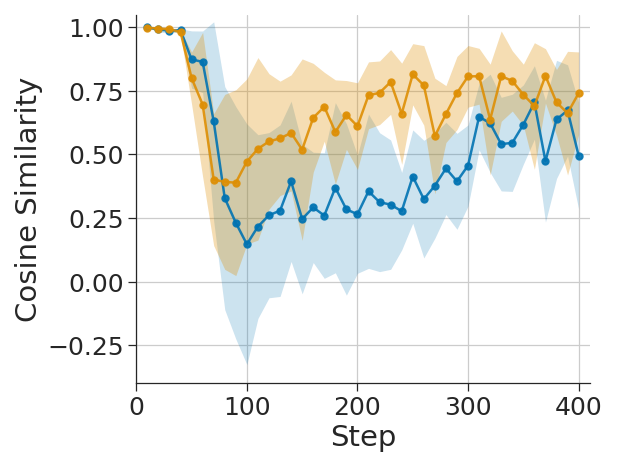

In [32]:
plt.plot(grad_sims["steps"], grad_sims["all"].mean(1), '.-', alpha=0.9)
plt.fill_between(
    grad_sims["steps"], 
    grad_sims["all"].mean(1) + grad_sims["all"].std(1), 
    grad_sims["all"].mean(1) - grad_sims["all"].std(1), 
    color="C0", 
    alpha=0.2
)
plt.plot(grad_sims["steps"], grad_sims["easy"].mean(1), '.-', alpha=0.9)
plt.fill_between(
    grad_sims["steps"], 
    grad_sims["easy"].mean(1) + grad_sims["easy"].std(1), 
    grad_sims["easy"].mean(1) - grad_sims["easy"].std(1), 
    color="C1", 
    alpha=0.3
)
plt.xlabel("Step")
plt.ylabel("Cosine Similarity")
plt.ylim(-0.4, 1.05)
plt.xlim(0, 410)
plt.savefig("sim.svg")